In [1]:
# ! pip install --upgrade tensorflow==2.16.1
# ! pip install --upgrade keras

In [52]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.optimizers import Nadam

In [25]:
print(tf.__version__)

2.10.0


In [26]:
data = pd.read_csv("convert_numeric.csv", delimiter=",")

In [27]:
data.head()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,gender,marital_status,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,0,6,1,3,1169,4,1,4,1,3,...,2,67,1,1,2,1,1,1,1,1
1,2,48,3,3,5951,0,2,2,0,1,...,2,22,1,1,1,1,1,0,1,0
2,3,12,1,9,2096,0,3,2,1,3,...,2,49,1,1,1,3,2,0,1,1
3,0,42,3,7,7882,0,3,2,1,3,...,0,45,1,0,1,1,2,0,1,1
4,0,24,2,1,4870,0,2,3,1,3,...,3,53,1,0,2,1,2,0,1,0


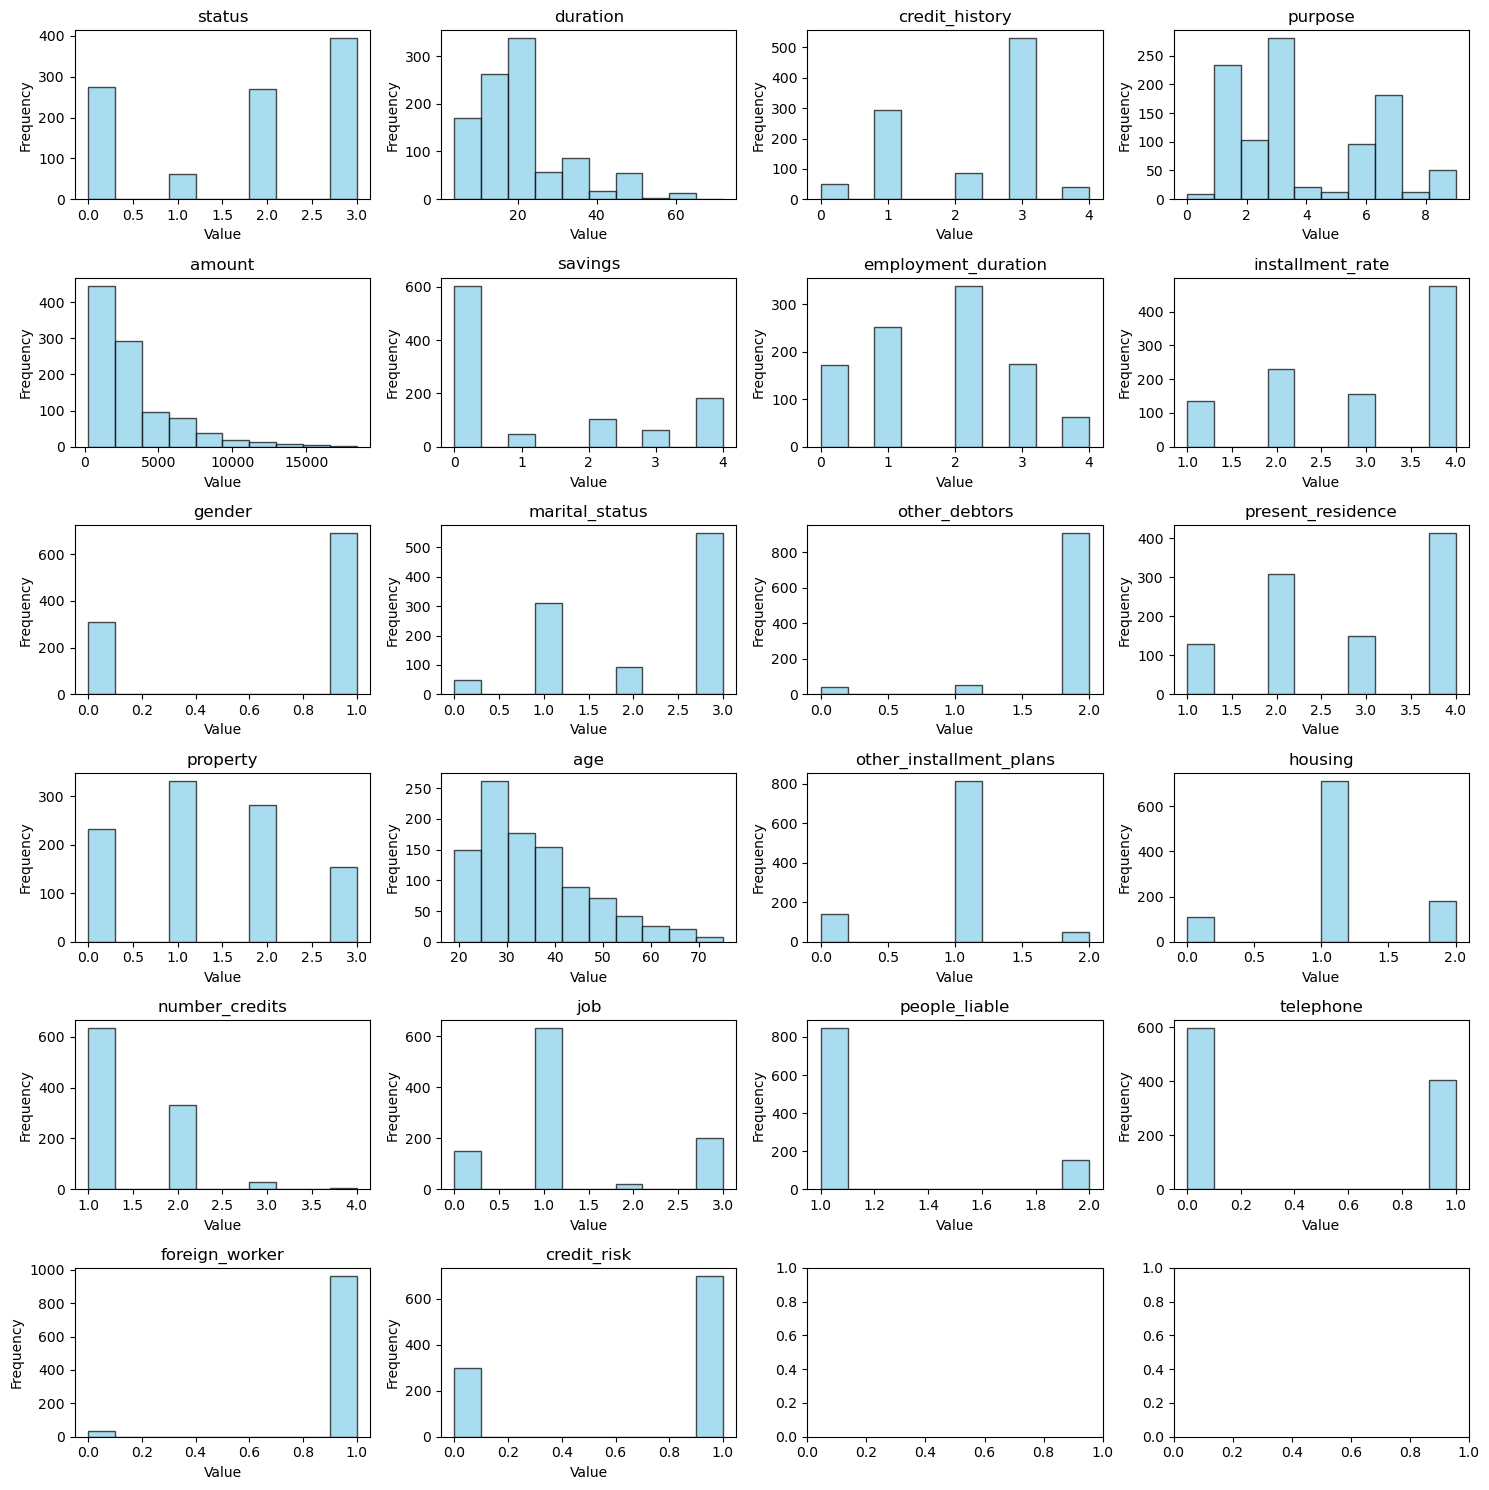

In [29]:
import matplotlib.pyplot as plt

# Assuming you have already loaded the data into 'data' using pd.read_csv

# Create a figure with subplots (6 rows, 4 columns)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Flatten the 2D array of axes for easy iteration
axes = axes.flatten()

# Iterate over each column and create a histogram on a subplot
for i, column in enumerate(data.columns):
    axes[i].hist(data[column], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
X = data.drop('credit_risk', axis=1)  
y = data['credit_risk']
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Terapkan StandardScaler ke fitur
X_normalized = scaler.fit_transform(X)

# Konversi hasil normalisasi kembali ke DataFrame
X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

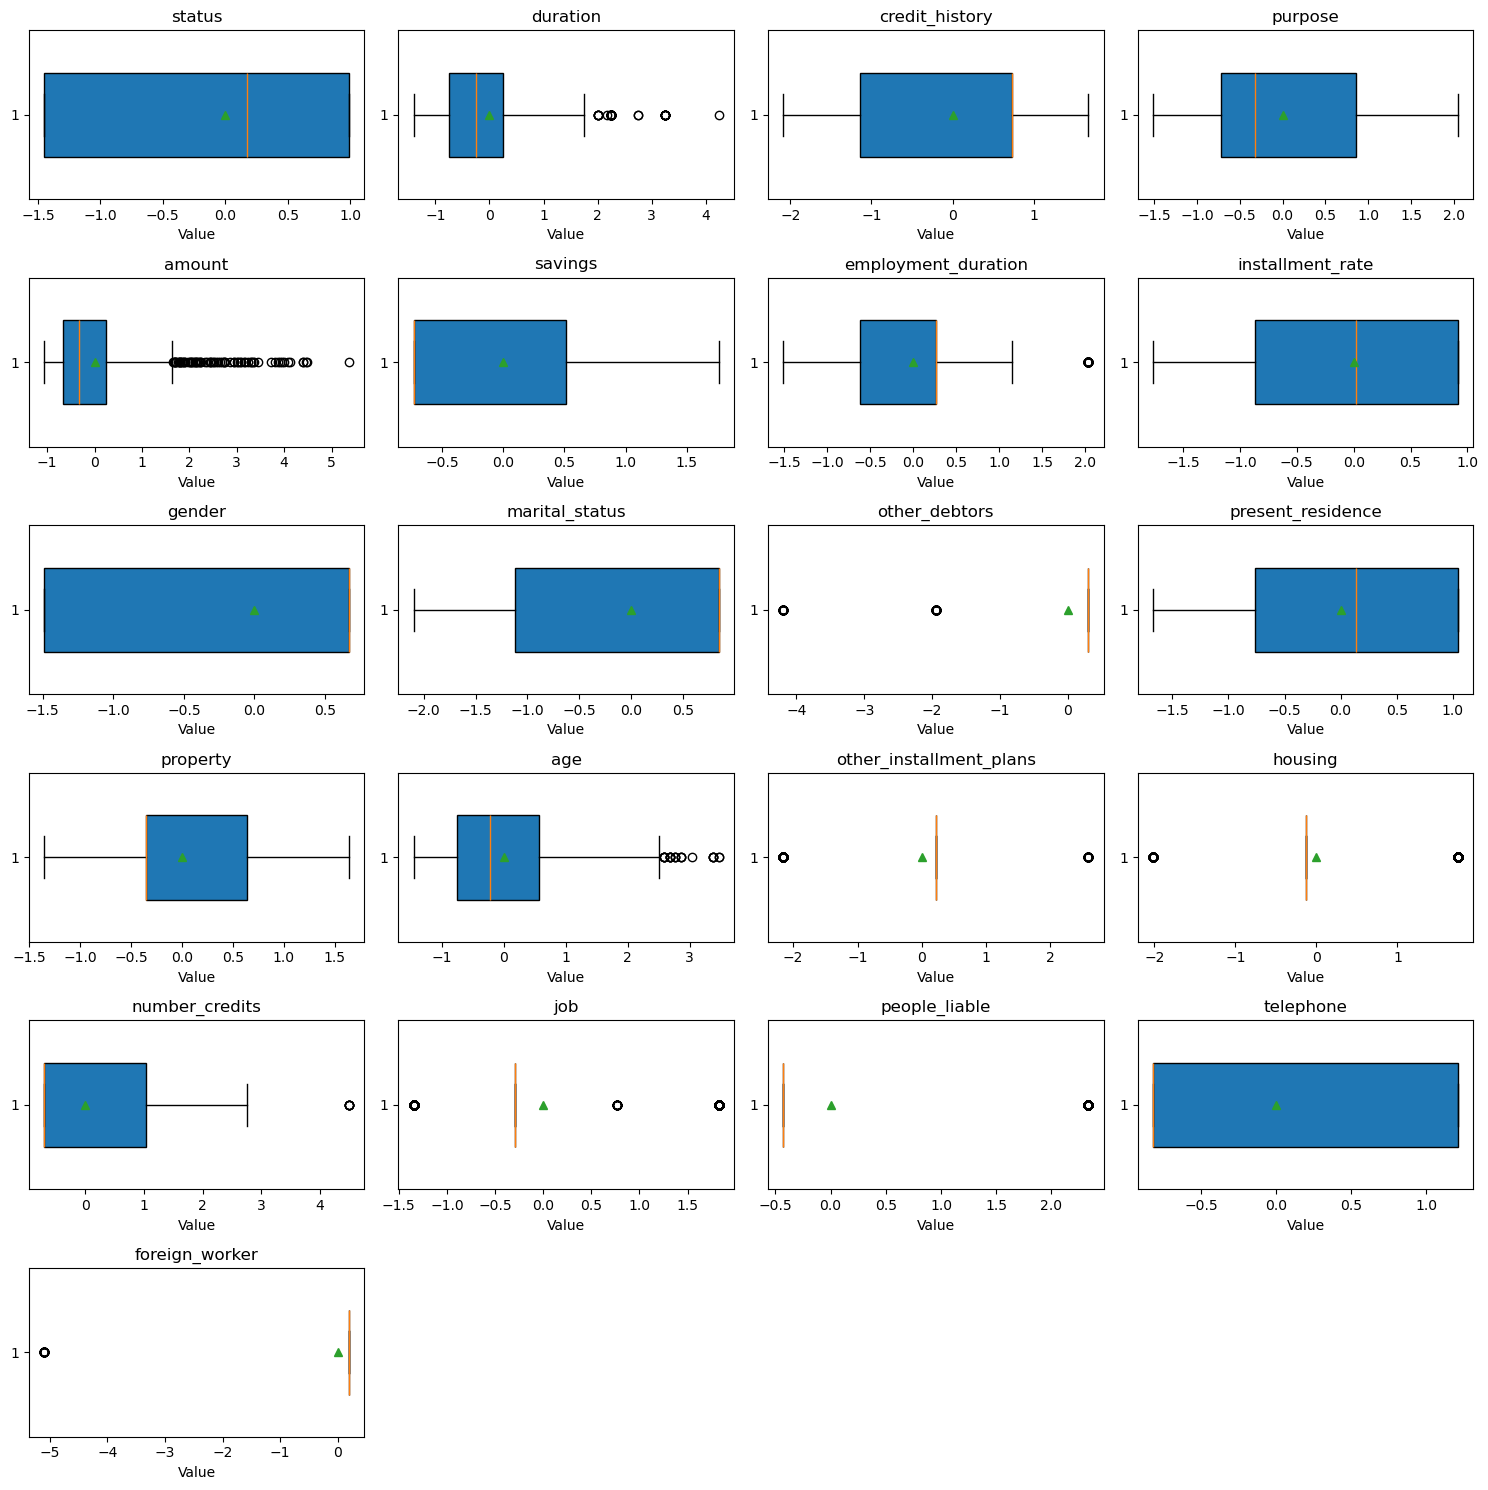

In [31]:
# Membuat figure dengan subplots (6 baris, 4 kolom)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Meratakan array 2D dari axes untuk iterasi yang lebih mudah
axes = axes.flatten()

# Iterasi setiap kolom dan membuat boxplot pada subplot
for i, column in enumerate(X_normalized_df.columns):
    axes[i].boxplot(X_normalized_df[column].values, vert=False, patch_artist=True, showmeans=True, widths=0.5)  # Horizontal boxplot with mean marker
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')

# Sembunyikan subplot yang tidak terpakai
for j in range(len(X_normalized_df.columns), len(axes)):
    fig.delaxes(axes[j])

# Sesuaikan layout untuk mencegah tumpang tindih judul
plt.tight_layout()

# Tampilkan plot
plt.show()

In [32]:
# Daftar kolom dengan outlier
columns_with_outliers = ['duration', 'amount', 'savings', 'employment_duration', 'installment_rate', 
                         'other_debtors', 'age', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

# Terapkan winsorization pada setiap kolom
for col in columns_with_outliers:
    X_normalized_df[col] = winsorize(X_normalized_df[col], limits=[0.01, 0.09]) 

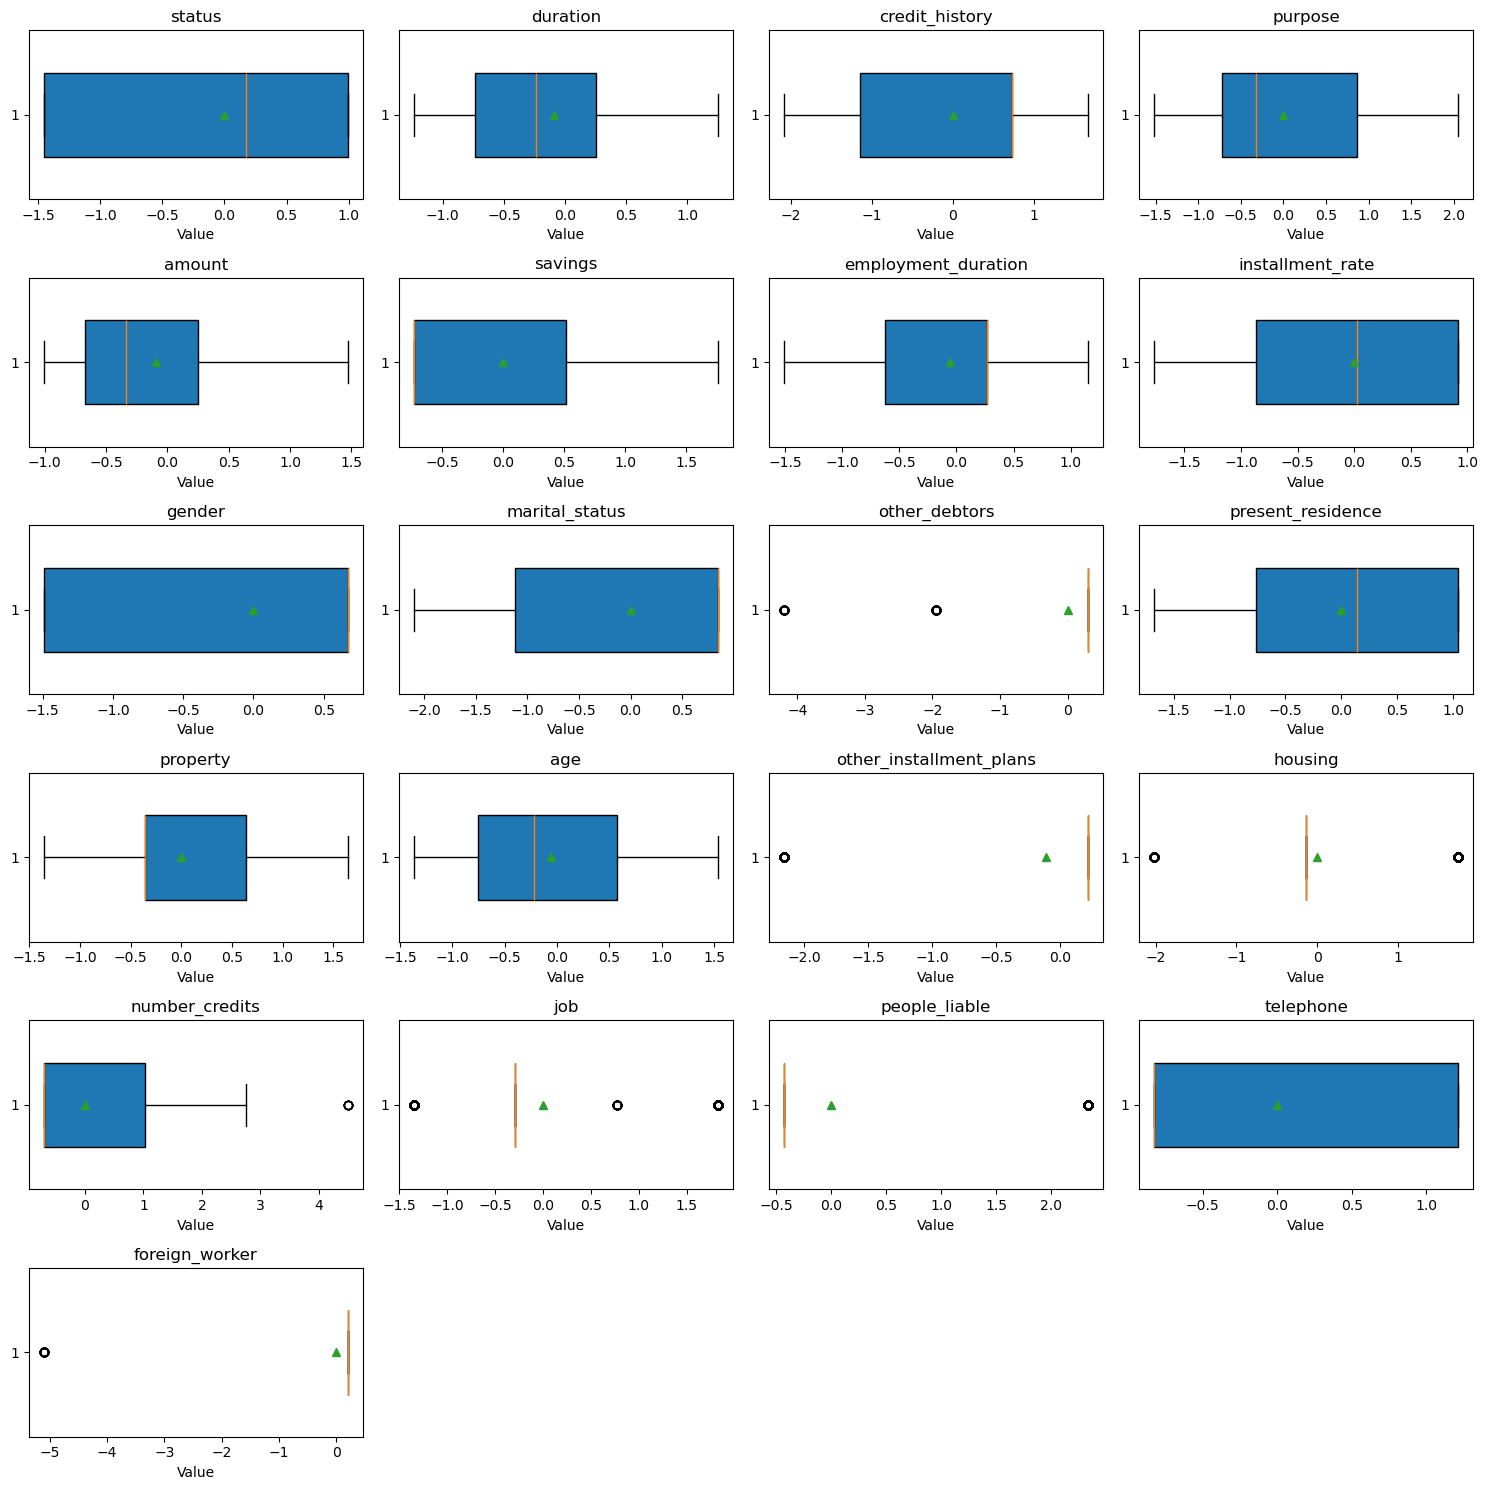

In [33]:
# Membuat figure dengan subplots (6 baris, 4 kolom)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Meratakan array 2D dari axes untuk iterasi yang lebih mudah
axes = axes.flatten()

# Iterasi setiap kolom dan membuat boxplot pada subplot
for i, column in enumerate(X_normalized_df.columns):
    axes[i].boxplot(X_normalized_df[column].values, vert=False, patch_artist=True, showmeans=True, widths=0.5)  # Horizontal boxplot with mean marker
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')

# Sembunyikan subplot yang tidak terpakai
for j in range(len(X_normalized_df.columns), len(axes)):
    fig.delaxes(axes[j])

# Sesuaikan layout untuk mencegah tumpang tindih judul
plt.tight_layout()

# Tampilkan plot
plt.show()

In [34]:
# Reshape X for the CNN: (samples, time steps, features)
X_cnn = X_normalized_df.values.reshape(X_normalized_df.shape[0], X_normalized_df.shape[1], 1)

# Split data menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)   

In [36]:
# Menyeimbangkan data pelatihan menggunakan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[1]), y_train)
X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1)

In [37]:
correlation_matrix = X.corrwith(y_train)
print("Korelasi fitur dengan target:")
print(correlation_matrix)

Korelasi fitur dengan target:
status                     0.290741
duration                  -0.201824
credit_history            -0.112102
purpose                   -0.047322
amount                    -0.163245
savings                    0.125372
employment_duration        0.009887
installment_rate          -0.044767
gender                     0.090616
marital_status             0.104205
other_debtors             -0.002050
present_residence         -0.009999
property                  -0.030593
age                        0.138957
other_installment_plans    0.070455
housing                   -0.015638
number_credits             0.033493
job                        0.060964
people_liable              0.004999
telephone                  0.028815
foreign_worker            -0.080573
dtype: float64


In [53]:
# Membuat model CNN
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_smote.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Kompilasi model dengan optimizer Nadam dan learning rate decay
optimizer = Nadam(learning_rate=0.001, decay=1e-6)
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping dengan monitoring val_loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Latih model dengan early stopping
history = model.fit(X_train_smote, y_train_smote, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
35/35 [==============================] - 1s 12ms/step - loss: 2.2875 - accuracy: 0.5027 - val_loss: 1.9635 - val_accuracy: 0.4800
Epoch 2/100
35/35 [==============================] - 0s 5ms/step - loss: 2.0366 - accuracy: 0.5608 - val_loss: 1.8869 - val_accuracy: 0.3800
Epoch 3/100
35/35 [==============================] - 0s 6ms/step - loss: 1.9157 - accuracy: 0.5796 - val_loss: 1.7940 - val_accuracy: 0.3850
Epoch 4/100
35/35 [==============================] - 0s 5ms/step - loss: 1.7780 - accuracy: 0.6306 - val_loss: 1.7327 - val_accuracy: 0.4100
Epoch 5/100
35/35 [==============================] - 0s 5ms/step - loss: 1.6801 - accuracy: 0.6404 - val_loss: 1.6947 - val_accuracy: 0.3700
Epoch 6/100
35/35 [==============================] - 0s 5ms/step - loss: 1.5817 - accuracy: 0.6377 - val_loss: 1.6424 - val_accuracy: 0.3800
Epoch 7/100
35/35 [==============================] - 0s 5ms/step - loss: 1.4790 - accuracy: 0.6753 - val_loss: 1.5960 - val_accuracy: 0.4050
Epoch 8/100


7/7 [==============================] - 0s 2ms/step - loss: 0.8271 - accuracy: 0.6600
Test Loss: 0.827, Test Accuracy: 0.660


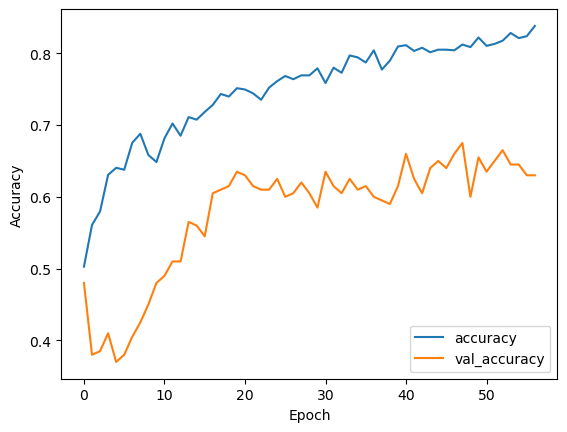

7/7 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.43      0.46      0.44        59
           1       0.77      0.74      0.76       141

    accuracy                           0.66       200
   macro avg       0.60      0.60      0.60       200
weighted avg       0.67      0.66      0.66       200



In [54]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}")

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Predict probabilities on test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))